# 套件宣告

In [1]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import np_utils

D:\Program\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import dlib
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import imutils
from imutils.face_utils import *
import os
from os import listdir
import pickle
import pandas as pd
import sys
from beauty_detector.align import AlignDlib
import time

from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
%matplotlib inline

# 臉部識別函數宣告

In [3]:
#讀取評分數據
rating_dict={}
with open('./beauty_detector/All_labels.txt','rb') as label:
    datalines = label.readlines()
    for d in datalines:
        d = str(d).replace('b','').replace('\\n','').replace("'","").split(' ')
        rating_dict[d[0]] = float(d[1])
        

def get_face(img):
    #產生臉部識別
    face_rects = detector(img, 1)
    for i, d in enumerate(face_rects):
        #讀取框左上右下座標
        x1 = d.left()
        y1 = d.top()
        x2 = d.right()
        y2 = d.bottom()
        #根據此座標範圍讀取臉部特徵點
        shape = landmark_predictor(img, d)
        #將特徵點轉為numpy
        shape = shape_to_np(shape)# (68,2)    
        # 透過dlib挖取臉孔部分，將臉孔圖片縮放至256*256的大小，並存放於pickle檔中
        # 人臉圖像部分呢。很簡單，只要根據畫框的位置切取即可crop_img = img[y1:y2, x1:x2, :]
        crop_img = img[y1:y2, x1:x2, :]   
        try:
            crop_img = cv2.resize(crop_img, (128, 128))         
            return crop_img   
        except:
            return np.array([0])  
    return np.array([0]) 

# def get_face(img):
#     #產生臉部識別
#     opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)  # predict target
#     opencvImage = opencvImage[..., ::-1]
#     alignment = AlignDlib('./beauty_detector/landmarks.dat')
#     # Detect face and return bounding box
#     bb = alignment.getLargestFaceBoundingBox(opencvImage)
#     # Transform image using specified face landmark indices and crop image to 96x96
#     opencvImage = alignment.align(128, opencvImage, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)
#     return opencvImage

# def get_face(img):
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     faces = detector(gray, 1)
 
#     for face in faces:
#         (x, y, w, h) = rect_to_bb(face)
#         faceOrig = imutils.resize(img[y : y+h, x : x+w], width=128)
#         faceAligned = fa.align(img, gray, face)
#         plt.imshow(cv2.cvtColor(faceAligned, cv2.COLOR_BGR2RGB))
#         return faceAligned

# 顏值特徵擷取

In [4]:
def load_dataset():
    global detector ,landmark_predictor
    #宣告臉部偵測器，以及載入預訓練的臉部特徵點模型
    detector = dlib.get_frontal_face_detector()
    landmark_predictor = dlib.shape_predictor('./beauty_detector/shape_predictor_68_face_landmarks.dat')

#     global detector ,fa
#     detector = dlib.get_frontal_face_detector()
#     predictor = dlib.shape_predictor("./beauty_detector/shape_predictor_68_face_landmarks.dat")
#     fa = FaceAligner(predictor, desiredFaceWidth=128)
    
    files = './beauty_detector/Images'
    image_data_list = []
    label = []
    start = time.time()
    # 以迴圈處理
    error = []
    for idx,f in enumerate(os.listdir(files)):
        # 產生檔案的絕對路徑
        fullpath = os.path.join(files, f)
        img = cv2.imread(fullpath)
        face = get_face(img)
        if (face.shape != (1,)) :
            image_data_list.append(img_to_array(face))
            label.append(rating_dict[f]) 
        else:
            error.append(f)
            print(fullpath)
        if (idx%100==0)and (idx>0):        
            print("{} detect success , use time:{:2f}s".format(idx - len(error),time.time() - start))
        del fullpath,img,face
        
    img_data = np.array(image_data_list)
    img_data = img_data.astype('float32')
    img_data /= 255        
    return img_data, label 

train_x, train_y = load_dataset()
train_x.shape

./beauty_detector/Images\AF1053.jpg
99 detect success , use time:9.242728s
199 detect success , use time:18.363535s
299 detect success , use time:27.456340s
./beauty_detector/Images\AF1330.jpg
398 detect success , use time:36.545155s
498 detect success , use time:45.625984s
./beauty_detector/Images\AF1479.jpg
597 detect success , use time:55.155576s
697 detect success , use time:64.637340s
./beauty_detector/Images\AF1678.jpg
796 detect success , use time:74.405072s
896 detect success , use time:83.822511s
996 detect success , use time:93.292324s
./beauty_detector/Images\AF1935.jpg
1095 detect success , use time:102.706786s
1195 detect success , use time:112.615328s
1295 detect success , use time:122.002657s
1395 detect success , use time:131.370943s
1495 detect success , use time:141.125024s
1595 detect success , use time:150.624033s
./beauty_detector/Images\AF722.jpg
1694 detect success , use time:160.022430s
1794 detect success , use time:169.449894s
./beauty_detector/Images\AF849.jp

(5483, 128, 128, 3)

# DataSet輸出為npz檔

In [5]:
np.savez('./beauty_detector/my_archive.npz', data=train_x, label=train_y)
ds = np.load('./beauty_detector/my_archive.npz')
train_x,train_y = ds['data'],ds['label']
len(rating_dict.keys())

5500

# 建立顏值評分模型

In [6]:
def make_network():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(128, 128, 3)))
    model.add(Activation('relu'))
#     model.add(Conv2D(32, (3, 3)))
#     model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())    
    model.add(Dense(1))
    model.add(Activation('linear'))
    model.compile(loss ='mse',optimizer='adam')
    model.summary()
    return model
model = make_network()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 131073    
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total para

# 模型訓練

In [7]:
from keras.callbacks import *

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=2, 
    verbose=0, 
    mode='auto'
)

hist = model.fit(train_x, np.array(train_y), batch_size=32, epochs=1, verbose=1, callbacks=[early_stopping])

Epoch 1/1
5483/5483 [==============================] - 70s 13ms/step - loss: 3.1088


D:\Program\Anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


# 模型評估

In [8]:
model.evaluate(train_x,train_y)

5483/5483 [==============================] - 21s 4ms/step


0.3342518771073037

# 儲存模型%權重

In [9]:
# Save model
model.save('./beauty_detector/faceRank.h5')
model.save_weights('./beauty_detector/faceRank_weights.h5')
del model
from keras.models import load_model
global model
model = load_model('./beauty_detector/faceRank.h5')
model.load_weights('./beauty_detector/faceRank_weights.h5')

# 目標顏值預測

In [14]:
def predict_image(img_url):
    image = cv2.imread(img_url)
    face = get_face(image)
    face = face.astype('float32')
    face /= 255  
    image = img_to_array(face)
    img = image[np.newaxis,:,:]
    plt.axis('off')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    print("Predict Score : {}".format(model.predict(img)[0][0] * 20))    

Predict Score : 68.35575103759766


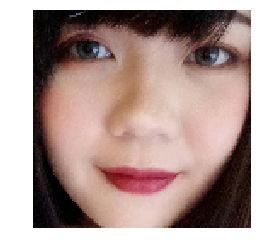

In [15]:
predict_image('./beauty_detector/abc.jpg')